In [8]:
import decode_eeg
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
import scipy.stats as sista
from statsmodels.stats.multitest import multipletests
import seaborn as sns
import pandas as pd

np.random.seed(42)
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
# Experiment setup
experiment_name = 'collinearity'
data_dir = f'data/collinearity'
exp = decode_eeg.Experiment(experiment_name,data_dir,test=False,info_variable_names=['sampling_rate','times'])

In [10]:
# Classification parameters and setup
time_window = 100
time_step = 100
trial_average = 20
n_splits = 100
#0: 2 grouped, 1: 2 ungrouped, 2: 4 grouped, 3: 4 ungrouped 
group_dict = {0:[1],1:[2],2:[3]}
wrangl = decode_eeg.Wrangler(exp.info['times'],time_window,time_step,trial_average,n_splits,group_dict)

clfr = decode_eeg.Classification(wrangl,exp.nsub,num_labels=3)
clfr.classifier = LogisticRegression()

In [87]:
# If you want to retrain classifiers, run this cell. Otherwise go to next cell.

clfr.confidence_scores = np.empty((exp.nsub,len(wrangl.t),wrangl.n_splits,clfr.num_labels))
for isub in range(exp.nsub):
    print(isub)
    xdata,ydata = exp.load_eeg(isub)
    
    # Reshaping data into [trials,electrodes,timepoints]
    xdata = np.moveaxis(xdata,[0,1,2],[2,0,1])
    xdata,ydata = wrangl.setup_data(xdata,ydata)

    for X_train_all, X_test_all, y_train, y_test in wrangl.train_test_split(xdata,ydata):
        
        # remove 4G from training, only train on 2U and 2G
        X_train_all = X_train_all[((y_train == 0) + (y_train == 2))]
        # test on 4G, 2U, and 4U
        y_train = y_train[((y_train == 0) + (y_train == 2))] 
        
        # shuffle labels for chance classification
        y_test_shuffle = np.random.permutation(y_test)
        
        for X_train, X_test in wrangl.roll_over_time(X_train_all, X_test_all):

            X_train, X_test = clfr.standardize(X_train, X_test)
            clfr.classifier.fit(X_train, y_train)

            clfr.acc[isub,wrangl.itime,wrangl.ifold] = clfr.classifier.score(X_test,y_test)
            clfr.acc_shuff[isub,wrangl.itime,wrangl.ifold] = clfr.classifier.score(X_test,y_test_shuffle)

            # get confidence of classification for each trial bin. >0 means set size 4 is predicted.
            confidence_scores = clfr.classifier.decision_function(X_test)
            for i in set(y_test):
                clfr.confidence_scores[isub,wrangl.itime,wrangl.ifold,i] = np.mean(confidence_scores[y_test==i])

# Set up interp object and save results.
interp = decode_eeg.Interpreter(clfr, subtitle = f'colinearity_preds')
interp.confidence_scores = clfr.confidence_scores
# interp.save_results(additional_values=['confidence_scores'])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


In [11]:
# Set up interp object and load pre-existing results. Skip if you ran previous cell.
interp = decode_eeg.Interpreter()
interp.load_results('collinearity.pickle')

In [12]:
def get_plot_line(a):
    """
    Takes in 2D array of shape [subjects,time points].
    Returns mean, and upper/lower SEM lines.
    """
    mean = np.mean(a,0)
    sem = sista.sem(a,0)
    upper,lower = mean + sem, mean - sem
    return mean, upper, lower

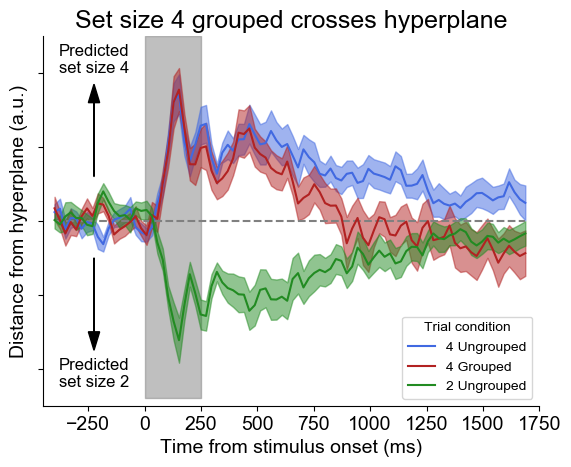

In [13]:
# Get means for each condition
ss2u = np.mean(interp.confidence_scores,2)[:,:,0]
ss4g = np.mean(interp.confidence_scores,2)[:,:,1]
ss4u = np.mean(interp.confidence_scores,2)[:,:,2]

# Plot confidence of classifier, which is proportional to distance from hyperplane.
stim_lower,stim_upper = -2.4,2.5
stim_time = [0,250]

ax = plt.subplot(111)

ax.fill_between(stim_time,[stim_lower,stim_lower],[stim_upper,stim_upper],color='gray',alpha=.5)
ax.plot(interp.t,np.zeros((len(interp.t))),'--',color='gray')
colors = ['royalblue','firebrick','forestgreen']

med, upper, lower = get_plot_line(ss4u)
ax.plot(interp.t,med,colors[0],label = '4 Ungrouped')
ax.fill_between(interp.t,upper,lower, color=colors[0],alpha=.5)

med, upper, lower = get_plot_line(ss4g)
ax.plot(interp.t,med,colors[1],label = '4 Grouped')
ax.fill_between(interp.t,upper,lower, color=colors[1], alpha=.5)

med, upper, lower = get_plot_line(ss2u)
ax.plot(interp.t,med,colors[2],label = '2 Ungrouped')
ax.fill_between(interp.t,upper,lower, color=colors[2], alpha=.5)

plt.legend(title='Trial condition',loc='lower right')

# aesthetics
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
plt.yticks(np.arange(-3,4,1),labels=['','','','','','',''])
plt.setp(ax.get_xticklabels(), fontsize=14)
plt.setp(ax.get_yticklabels(), fontsize=14)

plt.xlim(-450,1750)
plt.ylim([-2.5,2.5])

# labelling
plt.title('Set size 4 grouped crosses hyperplane',fontsize=18)
plt.xlabel('Time from stimulus onset (ms)', fontsize=14)
plt.ylabel('Distance from hyperplane (a.u.)', fontsize=14)

plt.text(-225,-2.25,'Predicted\nset size 2',fontsize=12,ha='center')
plt.text(-225,2,'Predicted\nset size 4',fontsize=12,ha='center')
plt.text(125,2.6,'Stim',fontsize=14,ha='center',c='white')
plt.arrow(-225,.6,0,1, head_width=50, head_length=.25,color='k')
plt.arrow(-225,-.5,0,-1,head_width=50, head_length=.25,color='k')

plt.savefig('output/figures/colinearity_hyperplane.png',dpi=500)
plt.savefig('output/figures/colinearity_hyperplane.pdf',dpi=500)

plt.show()

In [15]:
# time indexes
encoding = (interp.t>0) & (interp.t<250)
first_half = (interp.t>250) & (interp.t<1000)
second_half = (interp.t>1000)

# getting mean of each time period for each subject and condition
ss4u_mean_e = np.mean(ss4u[:,encoding],1)
ss4g_mean_e = np.mean(ss4g[:,encoding],1)
ss2u_mean_e = np.mean(ss2u[:,encoding],1)

ss4u_mean_1 = np.mean(ss4u[:,first_half],1)
ss4g_mean_1 = np.mean(ss4g[:,first_half],1)
ss2u_mean_1 = np.mean(ss2u[:,first_half],1)

ss4u_mean_2 = np.mean(ss4u[:,second_half],1)
ss4g_mean_2 = np.mean(ss4g[:,second_half],1)
ss2u_mean_2 = np.mean(ss2u[:,second_half],1)

data = np.concatenate([
    ss4u_mean_e,ss4g_mean_e,ss2u_mean_e,
    ss4u_mean_1,ss4g_mean_1,ss2u_mean_1,
    ss4u_mean_2,ss4g_mean_2,ss2u_mean_2])

# format data for seaborn
subs = np.tile(np.arange(len(ss4u_mean_e)),9)
condition = np.tile(np.repeat(['4 Ungrouped','4 Grouped','2 Ungrouped'],len(ss4u_mean_e)),3)
time = np.repeat(['Encoding','1st half','2nd half'],len(ss4u_mean_e)*3)
df = pd.DataFrame({'subject':subs, 'Condition':condition, 'Time period': time, 'Distance from hyperplane (a.u.)':data})

In [16]:
# get mean across subject of each time period and condition
means = df.groupby(['Time period','Condition']).mean()['Distance from hyperplane (a.u.)']
means

Time period  Condition  
1st half     2 Ungrouped   -0.826108
             4 Grouped      0.503299
             4 Ungrouped    0.877368
2nd half     2 Ungrouped   -0.304526
             4 Grouped     -0.260284
             4 Ungrouped    0.404239
Encoding     2 Ungrouped   -0.791352
             4 Grouped      0.775001
             4 Ungrouped    0.818014
Name: Distance from hyperplane (a.u.), dtype: float64

Ttest_relResult(statistic=0.5361651380176091, pvalue=0.2990331459319243)
Ttest_relResult(statistic=7.036870057536518, pvalue=5.330313751373458e-07)
Ttest_relResult(statistic=1.9181133685034284, pvalue=0.03512575448226677)
Ttest_relResult(statistic=4.629681397819832, pvalue=9.138426439545317e-05)
Ttest_relResult(statistic=1.8457820066047594, pvalue=0.04028273330686751)
Ttest_relResult(statistic=0.1910592381208881, pvalue=0.4252530017702582)


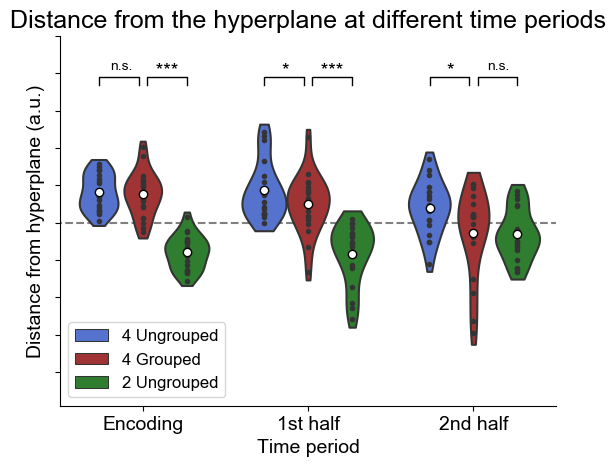

In [19]:
ax = sns.lineplot(x=[-1,3],y=[0,0],color='grey',linestyle='--')
plt.setp(ax.lines, zorder=-100)

my_pal = {"4 Ungrouped": "royalblue", "4 Grouped": "firebrick", "2 Ungrouped": "forestgreen"}
sns.violinplot(x='Time period',y='Distance from hyperplane (a.u.)', hue = 'Condition',data=df,dodge=True, palette=my_pal,inner='points', cut=.5)

# plotting means
plt.scatter(
    x = [-.265,0,.265,.735,1,1.265,1.735,2,2.265],
    y = [means[8],means[7],means[6],means[2],means[1],means[0],means[5],means[4],means[3]],
    c = 'white', edgecolors='k')

# aesthetics
plt.title('Distance from the hyperplane at different time periods',fontsize=18)
plt.xlabel('Time period',fontsize=14)
plt.ylabel('Distance from hyperplane (a.u.)', fontsize=14)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
plt.yticks(np.arange(-5,5.1,1),labels=['','','','','','',''])
plt.setp(ax.get_xticklabels(), fontsize=14)
plt.legend(loc='lower left',fontsize=12)

plt.ylim([-4.9,5])
plt.xlim([-.5,2.5])

# stats
print(sista.ttest_rel(a=ss4u_mean_e, b=ss4g_mean_e,alternative='greater'))
print(sista.ttest_rel(a=ss4g_mean_e, b=ss2u_mean_e,alternative='greater'))

print(sista.ttest_rel(a=ss4u_mean_1, b=ss4g_mean_1,alternative='greater'))
print(sista.ttest_rel(a=ss4g_mean_1, b=ss2u_mean_1,alternative='greater'))

print(sista.ttest_rel(a=ss4u_mean_2, b=ss4g_mean_2,alternative='greater'))
print(sista.ttest_rel(a=ss4g_mean_2, b=ss2u_mean_2,alternative='greater'))

plt.plot([-.265,-.265,-.025,-.025], [3.7, 3.9, 3.9, 3.7], linewidth=1, color='k')
plt.text(x=-.13,y=4.1,s='n.s.',ha='center')
plt.plot([.025,.025,.265,.265], [3.7, 3.9, 3.9, 3.7], linewidth=1, color='k')
plt.text(x=.1125,y=3.9,s='  ***',ha='center',fontsize=14)

plt.plot([.735,.735, .975,.975], [3.7, 3.9, 3.9, 3.7], linewidth=1, color='k')
plt.text(x=.86,y=3.925,s='*',ha='center',fontsize=14)
plt.plot([1.025,1.025,1.265,1.265], [3.7, 3.9, 3.9, 3.7], linewidth=1, color='k')
plt.text(x=1.1125,y=3.9,s='  ***',ha='center',fontsize=14)

plt.plot([1.735,1.735, 1.975,1.975], [3.7, 3.9, 3.9, 3.7], linewidth=1, color='k')
plt.text(x=1.86,y=3.925,s='*',ha='center',fontsize=14)
plt.plot([2.025,2.025,2.265,2.265], [3.7, 3.9, 3.9, 3.7], linewidth=1, color='k')
plt.text(x=2.15,y=4.1,s='n.s.',ha='center')


plt.savefig('output/figures/colinearity_hyperplane_periods.png',dpi=500)
plt.savefig('output/figures/colinearity_hyperplane_periods.pdf',dpi=500)

plt.show()